In [1]:
import os
os.chdir('../')
import logging
import numpy as np
import pytorch_lightning as pl
import pandas as pd
logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
# load meta-set
metaset_path = '/home/xlv0877/proj_home/dl/data/test/1000/mixscale/mixscale_filtered_w_emb.h5ad'
#metaset_path = 'data/subset_top_100_all_datasets.h5ad'
adata = sc.read(metaset_path)

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

### Assign parameters and prepare data

In [3]:
# assign number of cpus to use as data loaders
n_cpus = 10
seed = 42
min_cells = 50
N = 100             # Number of perturbations to subset
M = 10              # Number of perturbations to subset that are not included in :N
model_dir = 'models/gpa'
# define all labels to classify on
cls_labels = ['celltype', 'perturbation_type', 'perturbation']
# create classification label
adata.obs['cls_label'] = adata.obs[cls_labels].agg(';'.join, axis=1)
# define label in .obs to classify
cls_label = 'cls_label'
batch_key = 'dataset'
# add status label (control or perturbed)
adata.obs['status'] = 'perturbed'
adata.obs.loc[adata.obs['perturbation'] == 'control', 'status'] = 'ctrl'
# remove perturbations with less than minimum amount of cells
p_summary = adata.obs.cls_label.value_counts()
valid_perturbations = p_summary[p_summary >= min_cells].index
adata._inplace_subset_obs(adata.obs.cls_label.isin(valid_perturbations))
# Take a few perturbations out to later predict on
idx = np.where(adata.obs[cls_labels[-1]].isin(adata.obs[cls_labels[-1]].value_counts()[:N].index))[0]
idx_unseen = np.where(adata.obs[cls_labels[-1]].isin(adata.obs[cls_labels[-1]].value_counts()[N:N+M].index))[0]
unseen_adata = adata[idx_unseen].copy()
adata._inplace_subset_obs(idx)
# Select cells that have a match in the embedding
cells_annotated_mask = adata.obsm['gene_embedding'].sum(axis=1).A1!=0
# Select control cells to keep
ctrl_mask = adata.obs['perturbation']=='control'
embedding_mask = (cells_annotated_mask | ctrl_mask)
adata._inplace_subset_obs(embedding_mask)
# Check number of unique perturbations to classify
logging.info(f'Initializing dataset with {adata.obs.cls_label.nunique()} classes')

2025-05-22 08:39:45,165 - INFO - Initializing dataset with 165 classes


### Prepare model set

In [4]:
# choose set to train on
model_set = adata.copy()
likelihood = 'zinb'

if likelihood == 'normal':
    logging.info('Applying log1p and scaling data to force normal distribution')
    sc.pp.log1p(model_set)
    sc.pp.scale(model_set)
# model_set.write_h5ad(os.path.join(model_dir, '.cache.h5ad'))

### Set hyperparameters

In [5]:
# set model dir
class_labels = model_set.obs[cls_label].unique()
n_labels = len(class_labels)-1 if 'unknown' in class_labels else len(class_labels)  
# set scale for kl divergence
klr = 0.25
cr = 1

# hyperparameters for model
cls_params = {
    'n_hidden': 128, 'n_layers': 1, 'dropout_rate': 0.1
}
gpvae_params = {
    'n_hidden': 512,
    'n_latent': 256,
    'n_latent_g': 10,
    'n_layers_encoder': 2,
    'n_layers_encoder_g': 1,
    'n_layers_decoder': 2,
    'dropout_rate_encoder': 0.2,
    'dropout_rate_encoder_g': 0.2,
    'dispersion': 'gene',
    'use_batch_norm': 'both',
    'gene_likelihood': likelihood,
    'linear_classifier': False,
    'classifier_parameters': cls_params,
    'use_posterior_mean': False,
    'log_variational': likelihood == 'zinb',
    'mixup_lambda': 1,
    'corr_weight': 0,
}

tensor_dir = os.path.join(model_dir, f'n_{n_labels}')

data_params = {
    'train_size': 0.9,
    'batch_size': 128,
    'num_workers': 1
}
plan_params = {
    'lr': 1e-3,
    'weight_decay': 1e-6,
    'kl_weight': klr,
    'classification_ratio': cr,
    'lr_scheduler_metric': 'elbo_validation',
    'n_epochs_cls_warmup': 400,
    'n_epochs_cls_stall': 0,
    'min_cls_weight': 1,
    'max_cls_weight': 1,
    'plot_cm': False, 'plot_umap': False
}
train_params = {
    'max_epochs': 120,
    'early_stopping': False,
    'check_val_every_n_epoch': 1,
    'logger': pl.loggers.TensorBoardLogger(tensor_dir),
    'plan_kwargs': plan_params,
}
# Define covariates, set celltype as covariate
cat_covs = None
cont_covs = None

In [6]:
import torch
from src.models.gpvi import GPVI

torch.set_float32_matmul_precision('medium')
# Setup anndata with model
GPVI.setup_anndata(
    model_set, batch_key=batch_key, labels_key=cls_label, unlabeled_category='unknown',
    cls_labels=cls_labels,
    categorical_covariate_keys=cat_covs,
)
# Training parameters
gpvae = GPVI(model_set, **gpvae_params)

2025-05-22 08:40:34,756 - INFO - group: ('lymphoblasts', 'CRISPRi'): n_ctrl: 71619, n_pert: 51619
2025-05-22 08:40:34,778 - INFO - group: ('retinal pigment epithelial cells', 'CRISPRi'): n_ctrl: 30343, n_pert: 20343


INFO     Generating sequential column names                                                                        


2025-05-22 08:40:37,255 - WARNING - Got two different latent dimensions for X (256) and G (10).
This will likely lead to poor additive performance. Consider using "encoder" as update_method instead.


In [7]:
# Get model trainer
logging.info(f'Running at: {tensor_dir}')
gpvae.train(data_params=data_params, model_params=gpvae_params, train_params=train_params, return_runner=False)

2025-05-22 08:40:39,947 - INFO - Running at: models/gpa/n_165
2025-05-22 08:40:39,948 - INFO - Epochs suggested: 111, training for 120 epochs.
INFO: GPU available: True (cuda), used: True
2025-05-22 08:40:40,147 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-05-22 08:40:40,148 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-05-22 08:40:40,150 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-22 08:40:41,570 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'train_params' parameter because it is not possible to safely dump to YAML.
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-05-22 08:40:41,877 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-

Training:   0%|          | 0/120 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=120` reached.
2025-05-22 09:19:26,436 - INFO - `Trainer.fit` stopped: `max_epochs=120` reached.


### Check latent spaces

In [61]:
from src.utils.constants import MODULE_KEYS
# Check out latent space
latents = gpvae.get_latent_representation()
model_set.obsm[MODULE_KEYS.Z_KEY] = latents[MODULE_KEYS.Z_KEY]
model_set.obsm[MODULE_KEYS.ZG_KEY] = latents[MODULE_KEYS.ZG_KEY]

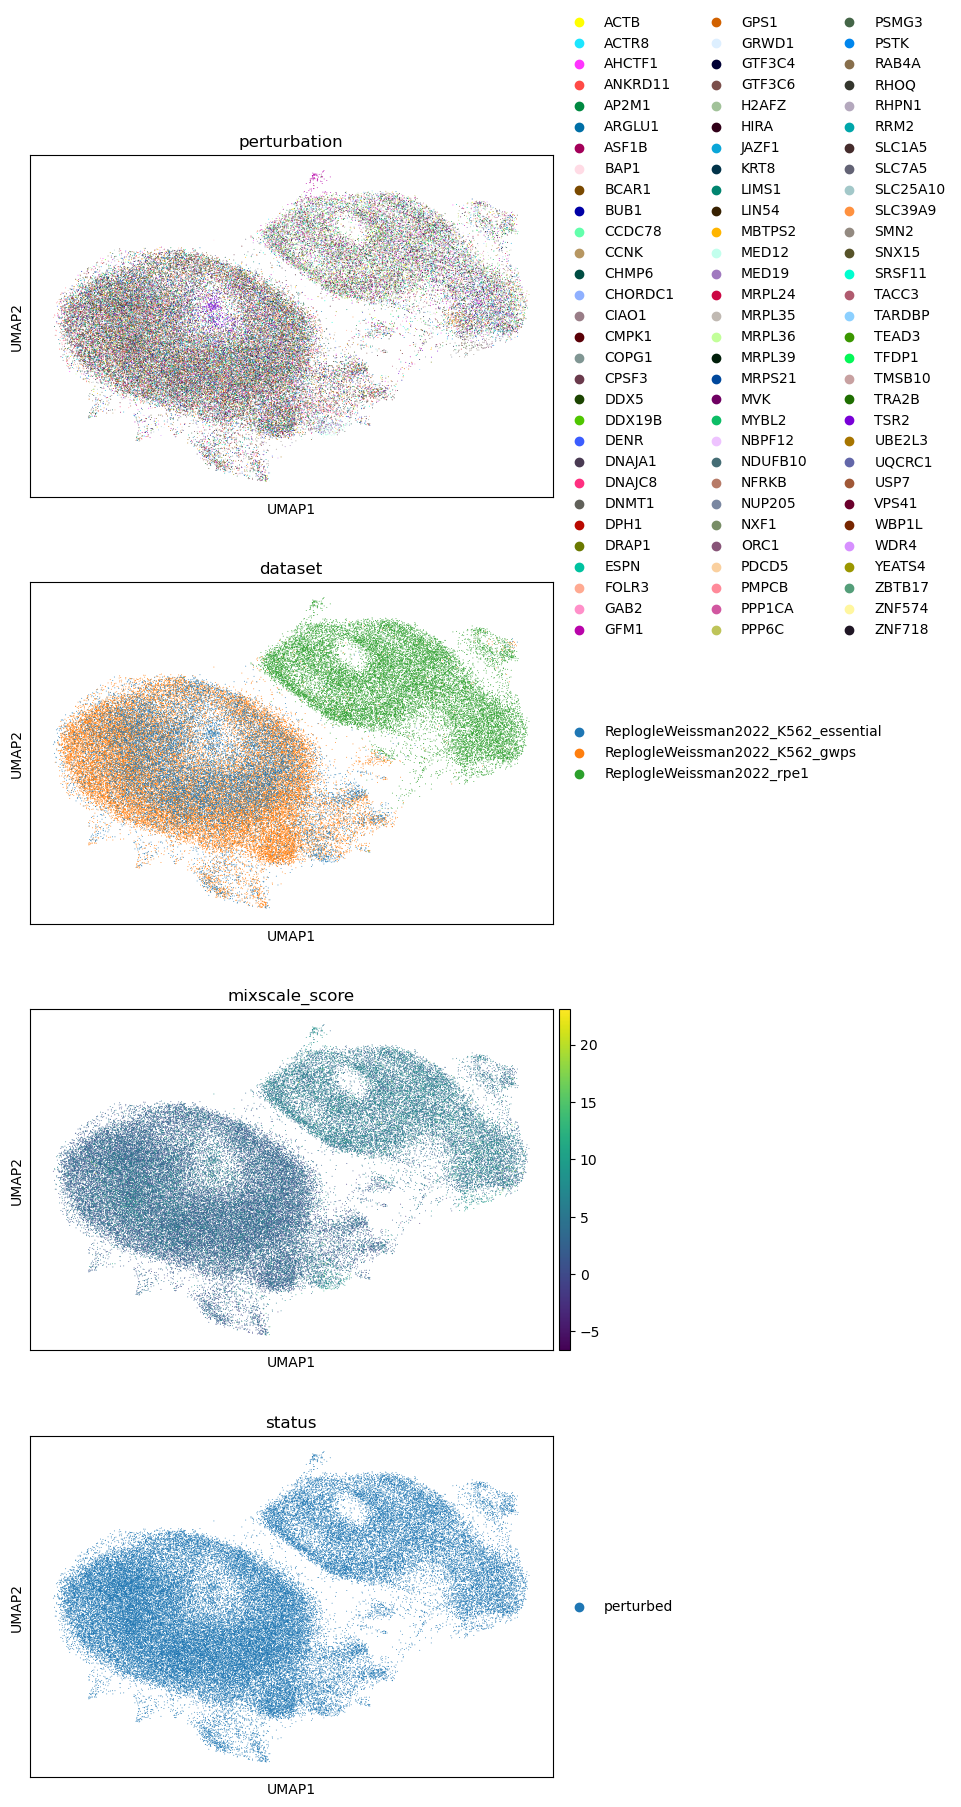

In [62]:
# Look at Z
sc.pp.neighbors(model_set, use_rep=MODULE_KEYS.Z_KEY)
sc.tl.umap(model_set)
sc.pl.umap(model_set, color=['perturbation', 'dataset', 'mixscale_score', 'status'], ncols=1)

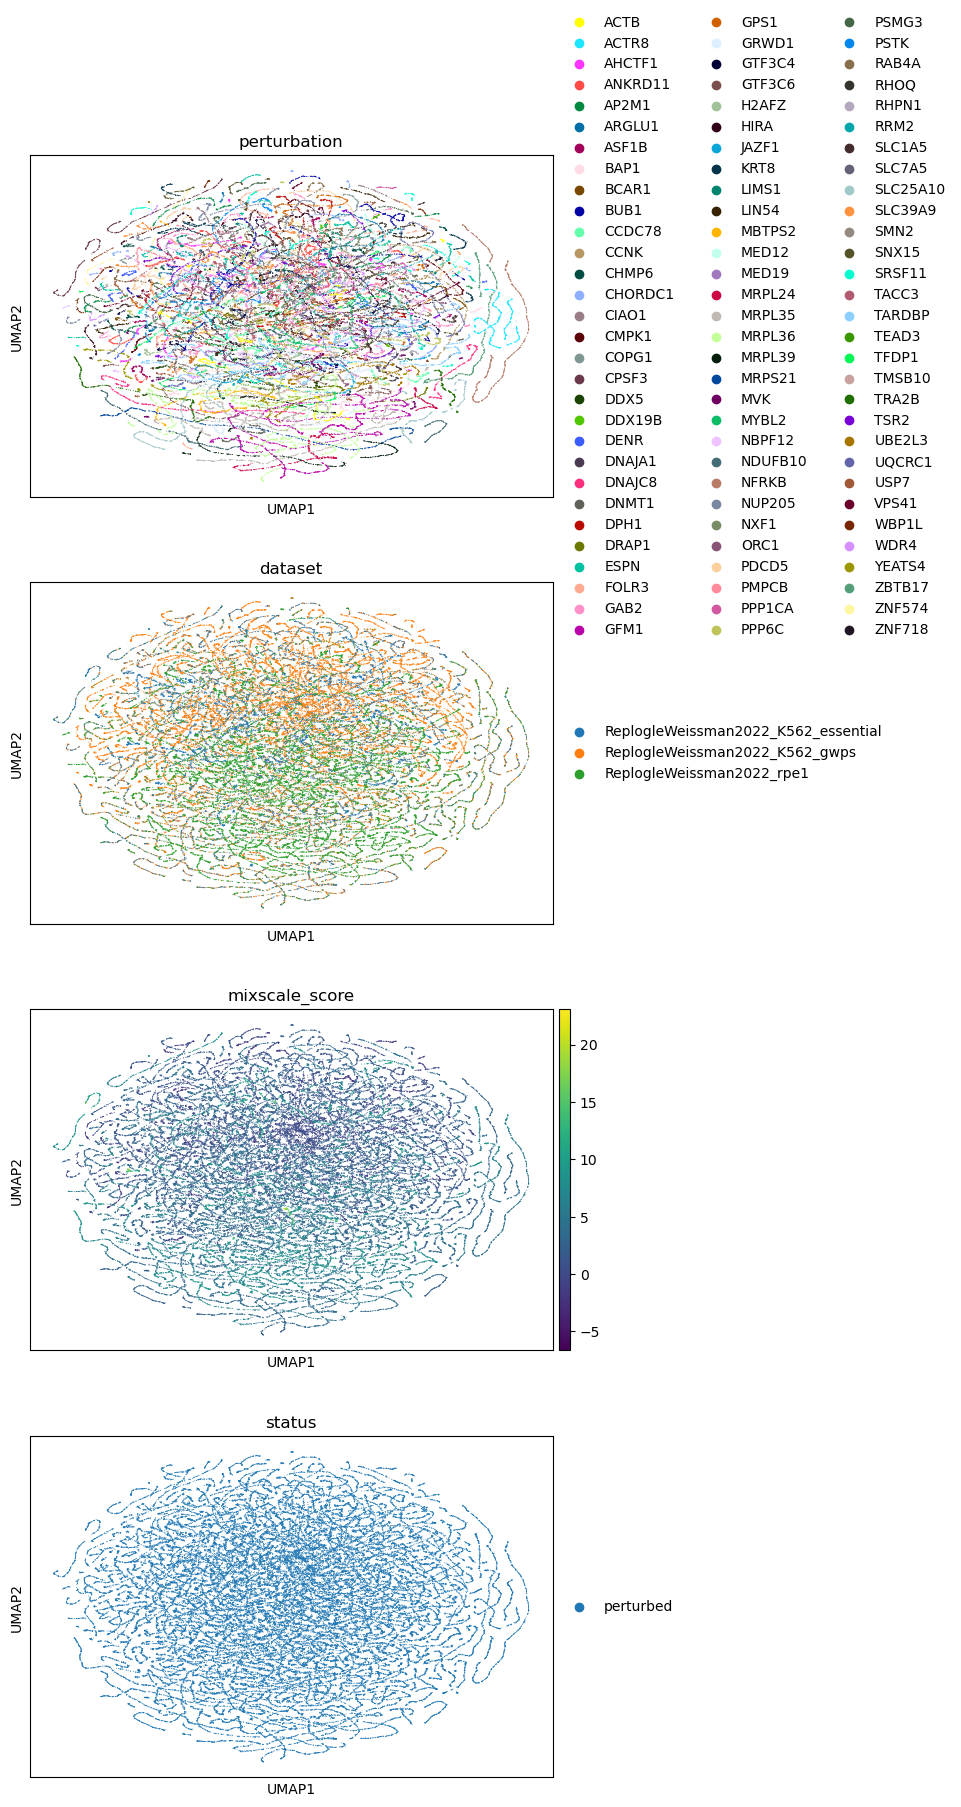

In [63]:
# Look at Z_g
sc.pp.neighbors(model_set, use_rep=MODULE_KEYS.ZG_KEY)
sc.tl.umap(model_set)
sc.pl.umap(model_set, color=['perturbation', 'dataset', 'mixscale_score', 'status'], ncols=1)

### Compute scVI model and 

### Check Correlation to perturbed expression

In [8]:
from scipy.stats import spearmanr
from tqdm.contrib.concurrent import process_map
import pandas as pd
from src.utils.constants import REGISTRY_KEYS

logging.info('Generating reconstructed expression')
model_set.layers['reconstructed'] = gpvae.get_normalized_expression(library_size='latent')

2025-05-22 09:19:29,941 - INFO - Generating reconstructed expression


In [9]:
logging.info('Calculating correlations')
label = 'cls_label'
workers = 10
unique_classes = model_set.obs[label].unique()

def compute_corr(c):
    cadata = model_set[model_set.obs[label] == c]
    raw_counts = cadata.X.todense()
    norm_expr = cadata.layers['reconstructed']
    basal_counts = cadata.layers[REGISTRY_KEYS.B_KEY].todense()
    corr, pval = spearmanr(raw_counts.flatten().A1, norm_expr.flatten())
    corr_b, pval_b = spearmanr(raw_counts.flatten().A1, basal_counts.flatten().A1)
    
    return c, {'Predicted': corr, 'pval': pval, 'Basal': corr_b, 'pval_basal': pval_b}

# process_map uses multiprocessing; use thread_map for I/O-heavy tasks
results = process_map(compute_corr, unique_classes, desc="Correlation", max_workers=workers)

# Convert to DataFrame
corr_results = pd.DataFrame(dict(results)).T
pl_df = corr_results.melt(id_vars=['pval', 'pval_basal'])

2025-05-22 09:19:42,151 - INFO - Calculating correlations


Correlation:   0%|          | 0/163 [00:00<?, ?it/s]

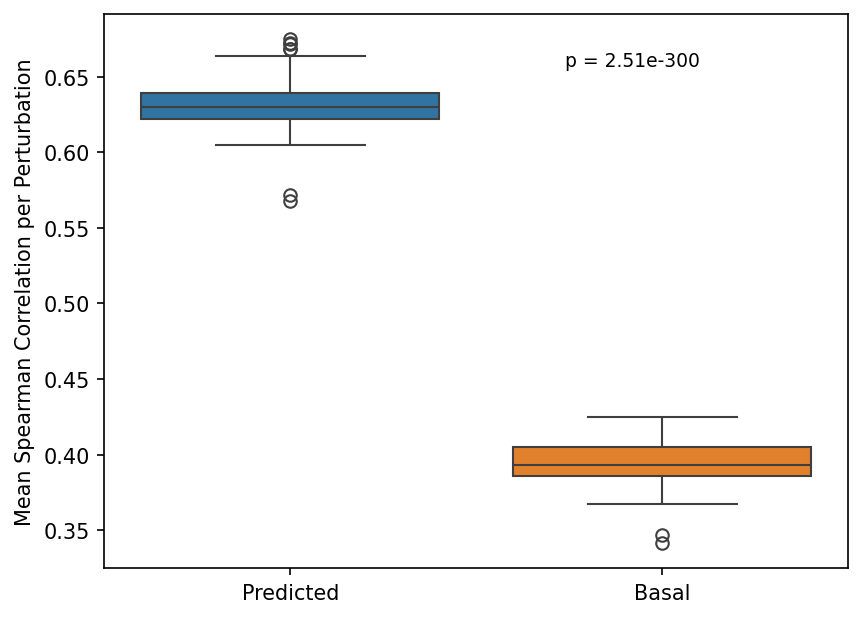

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Compute t-test between the two groups
group1 = pl_df[pl_df['variable'] == pl_df['variable'].unique()[0]]['value']
group2 = pl_df[pl_df['variable'] == pl_df['variable'].unique()[1]]['value']
t_stat, p_val = ttest_ind(group1, group2)

# Plot
fig = plt.figure(dpi=150)
ax = sns.boxplot(pl_df, x='variable', y='value', hue='variable')
#ax.set_xticklabels(['Perturbated', 'Basal'])
plt.xlabel('')
plt.ylabel('Mean Spearman Correlation per Perturbation')

# Add p-value text
ax.text(1.1, ax.get_ylim()[1]*0.95, f'p = {p_val:.2e}', ha='right', fontsize=9)

plt.show()

### Check performance vs. support correlation

In [26]:
# Add support for each perturbation to results
cpp = model_set.obs[label].value_counts().reset_index()
corr_results = corr_results.merge(cpp, left_index=True, right_on=label).sort_values('r2', ascending=False)

<Axes: xlabel='r2', ylabel='count'>

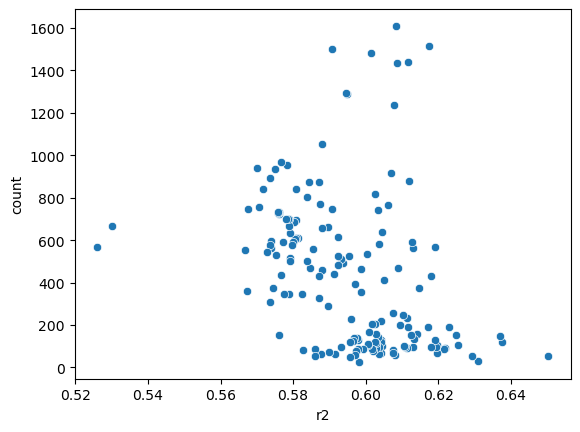

In [27]:
sns.scatterplot(corr_results, x='r2', y='count')

### Plot raw perturbed data

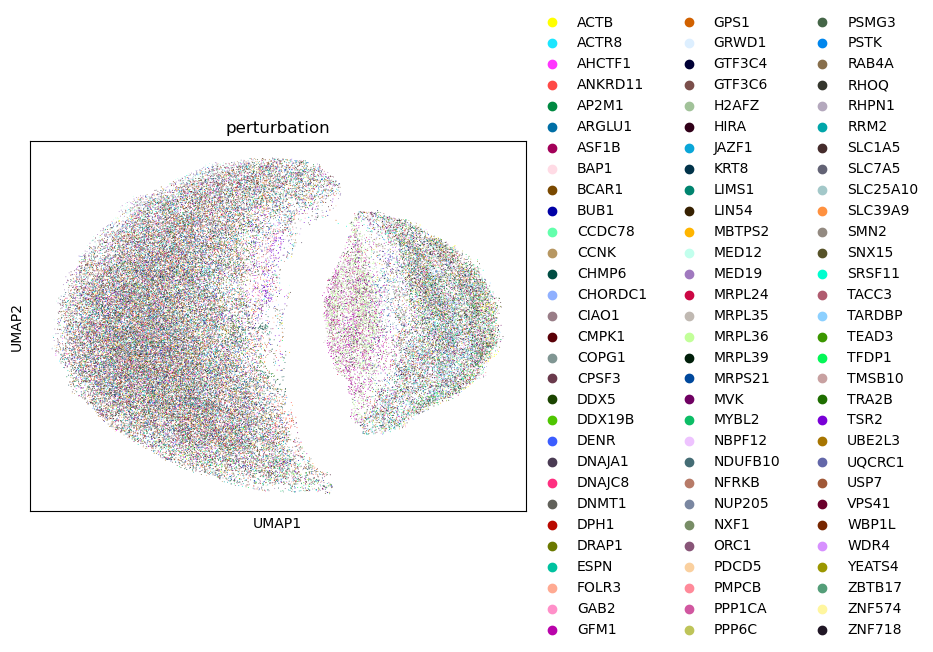

In [29]:
sc.pp.pca(model_set)
sc.pp.neighbors(model_set, n_neighbors=5)
sc.tl.umap(model_set)
sc.pl.umap(model_set, color='perturbation')

### Plot reconstructed data

... storing 'cls_label' as categorical
... storing 'status' as categorical


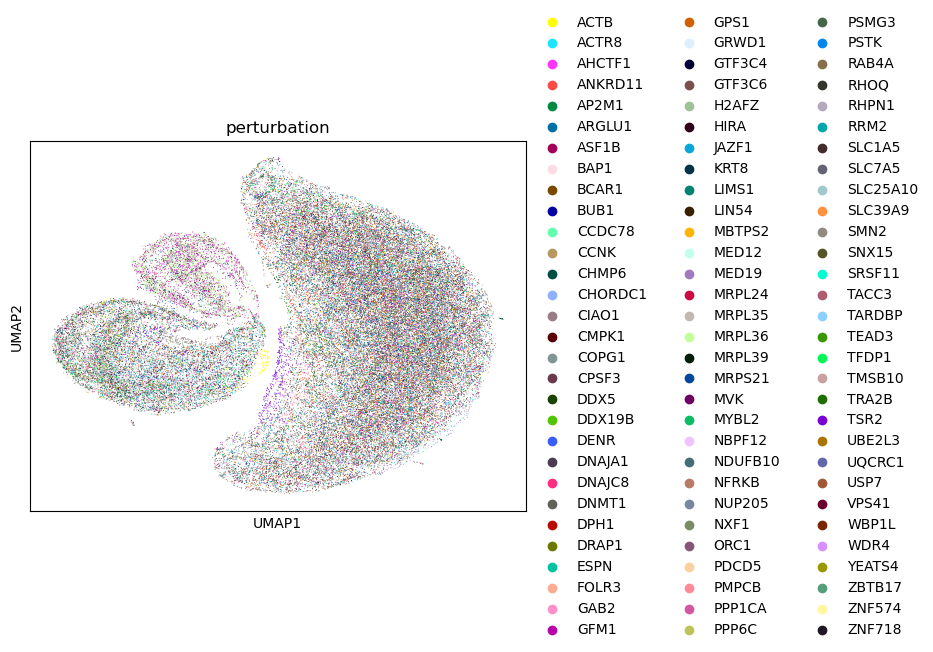

In [11]:
sc.pp.pca(model_set, layer='reconstructed')
sc.pp.neighbors(model_set, n_neighbors=5)
sc.tl.umap(model_set)
sc.pl.umap(model_set, color='perturbation')

2025-05-21 10:51:56,847 - INFO - Plotting X_pca
/tmp/ipykernel_1794075/4271564034.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(tmp)
... storing 'cls_label' as categorical
... storing 'status' as categorical


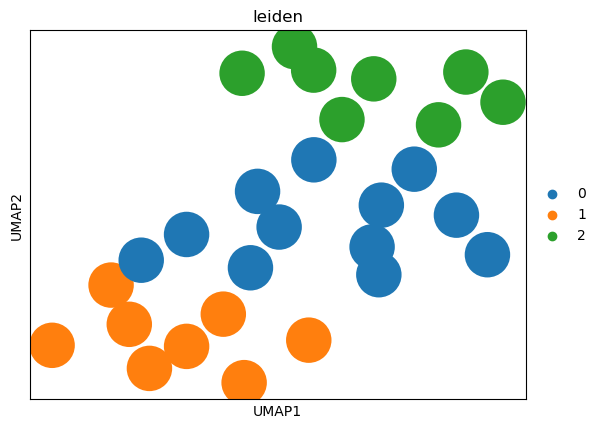

2025-05-21 10:51:58,688 - INFO - Plotting reconstructed


ValueError: Did not find reconstructed in `.obsm.keys()`. You need to compute it first.

In [14]:
# Check specific target perturbation
target = 'TEAD3'
tmp = model_set[model_set.obs['perturbation']==target]
p_layer = tmp.X
r_layer = tmp.layers['reconstructed']

    

In [29]:
model_set.layers['norm'] = sc.pp.normalize_total(model_set, inplace=False)['X']

In [30]:
sc.pp.log1p(model_set, layer='norm')